# Modules, colors, and functions

### Remove scroll from figures

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Extend the size of the Window

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Load Modules

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import convolution as conv
import datetime
import glob
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from pprint import pprint
import scipy as sp
from scipy.interpolate import griddata
from scipy import sparse, signal, stats
import sunpy.cm as cm
import sunpy.map
import sunpy.physics.differential_rotation as dr
%matplotlib inline

### Load and interface with Google Cloud Storage

In [4]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
client = storage.Client.from_service_account_json('/home/jupyter/service/Space Weather Solar Mag-3bbd387c6a34_AMJ.json')

### Remove Warnings and Define Color Defaults

You can switch colormaps between *hmimag* (*seismic*) if you want to focus on the *weak* (*strong*) magnetic features.

In [5]:
# Remove Warnings
# import warnings
# warnings.filterwarnings('ignore')

# Color Axis limits
vmin = -2000
vmax = 2000

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Colormap Definition
current_cmap = plt.cm.get_cmap('hmimag')
# current_cmap = plt.cm.get_cmap('seismic')
current_cmap.set_bad(color='black')

### Define functions to find files

In [6]:
def _deltaDate(date, ndays):
    """
    Function that returns a date object shifted by a number of days for vectorization

    :param date: date to shift
    :param ndays: Number of days in the timedelta
    :return:  timedelta
    """    
    return date+datetime.timedelta(days=float(ndays))

def searchMagnetograms(date, dtol=1, nresults=1, instrument='MDI'):
    """
    Function that looks for the closest observation to a date for a given instrument

    :param dateStr: datetime object
    :param dtol: number of dates of tolerance for the search
    :param nresults: top number of matches to return.  0 Returns all
    :param instrument: Text indicating the instrument that will be used in the search
    :return:  Pandas dataframe with the paths, the dates, and the time difference.
              If there is no match, the pandas dataframe is returned empty
    """
    
    print('Searching for closest', nresults, instrument, 'results within', dtol, 'days of' , date, '...', flush=True)

    # Dictionary with buckets
    buckets = {'MDI': 'fdl-mag-mdi',
               'HMI': 'fdl-mag-sdo',
               'SPMG': 'fdl-mag-spmg',
               'SOLIS': 'fdl-mag-solis'}
    
    # First day of the MDI mission
    MDIdate0 = datetime.datetime.fromisoformat('1993-01-01T00:00:00')    
    
    # Vectorize time shift function
    deltaDateV = np.vectorize(_deltaDate)
    # Find search range in days
    dateRange = deltaDateV(date, np.arange(-dtol, dtol+1))
    # Create dataframe for holding results
    closestFiles = pd.DataFrame(columns=['Path', 'Date', 'TimeDif', 'AbsTimeDif'])    
    
    # Connect to bucket
    bucket = client.get_bucket(buckets[instrument])
       
    for dateCheck in dateRange:
        
        if instrument == 'MDI':
            
            # Find files for range
            mdiDate = dateCheck.toordinal() - MDIdate0.toordinal()
            fileID = 'fd_M_96m_01d.' + str(mdiDate) + '.00' 
            path = str(dateCheck.year) + '/fd_M_96m_01d.00' + str(dateCheck.toordinal() - MDIdate0.toordinal() ) + '/'
            blobs = bucket.list_blobs(prefix=path)    

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if fileID in blob.name:

                    # Extract file number
                    tmpPos = blob.name.rfind(str(mdiDate))
                    fileNm = int(blob.name[tmpPos+7:tmpPos+9])
                    # Calculate time delta
                    timeDelta = datetime.timedelta(minutes=fileNm*96)
                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day) + timeDelta
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)

                    
        if instrument == 'HMI':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr + '/' + Mo + '/' + Dy + '/'
            blobs = bucket.list_blobs(prefix=path)               

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if 'magnetogram.fits' in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos-6:tmpPos-4])
                    mn = int(blob.name[tmpPos-4:tmpPos-2])
                    sc = int(blob.name[tmpPos-2:tmpPos])

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)

                    
        if instrument == 'SPMG':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)
            
            path = Yr[2:4] + Mo + '/'
            blobs = bucket.list_blobs(prefix=path)  

            # Scan Blobs
            for blob in blobs:

                # If one of the magnetograms is found
                if Yr+Mo+Dy in blob.name:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos+1:tmpPos+3])
                    mn = int(blob.name[tmpPos+3:tmpPos+5])
                    sc = 0

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)
                    
                    
        if instrument == 'SOLIS':
            
            # Turning date into strings
            Yr = str(dateCheck.year)
            Mo = str(dateCheck.month).zfill(2)
            Dy = str(dateCheck.day).zfill(2)


            # Looping through versions        
            for v in range(1,6):        

                # Find files for range
                path = Yr + Mo + '/k' + str(v) + 'v93' + Yr[2:4] + Mo + Dy + '/'
                blobs = bucket.list_blobs(prefix=path)    

                # Scan Blobs
                for blob in blobs:

                    # Deconstruct Name to assess date
                    tmpPos = blob.name.rfind('_')
                    hr = int(blob.name[tmpPos-6:tmpPos-4])
                    mn = int(blob.name[tmpPos-4:tmpPos-2])
                    sc = int(blob.name[tmpPos-2:tmpPos])

                    # Assemble date
                    tmpDate = datetime.datetime(dateCheck.year, dateCheck.month, dateCheck.day, hr, mn, sc)              
                    # Append entry
                    closestFiles = closestFiles.append({'Path': blob.name, 'Date': tmpDate, 'TimeDif': date-tmpDate, 'AbsTimeDif': abs(date-tmpDate)}, ignore_index=True)
                    
                             
    if closestFiles.shape[0] == 0:
        print('done. No', instrument, 'file found.', flush=True)
    else:
        print('done.', flush=True)
    print(' ', flush=True)
    
    # Sort according to time difference
    closestFiles = closestFiles.sort_values(by=['AbsTimeDif']).reset_index(drop=True)
    
    # Return all observations with 0 or a subset
    if nresults == 0:
        return closestFiles
    else:
        return closestFiles.loc[0:nresults-1,:]

In [7]:
dateStr = '2010-06-03T00:00:00'
date = datetime.datetime.fromisoformat(dateStr)

searchMagnetograms(date, instrument='HMI', nresults=1)

# ttt.shape

Searching for closest 1 HMI results within 1 days of 2010-06-03 00:00:00 ...
done.
 


,Path,Date,TimeDif,AbsTimeDif
0,2010/06/03/hmi.M_720s.20100603_000000_TAI.1.ma...,2010-06-03,0 days,0 days


# Instrument Coverage and Characteristics

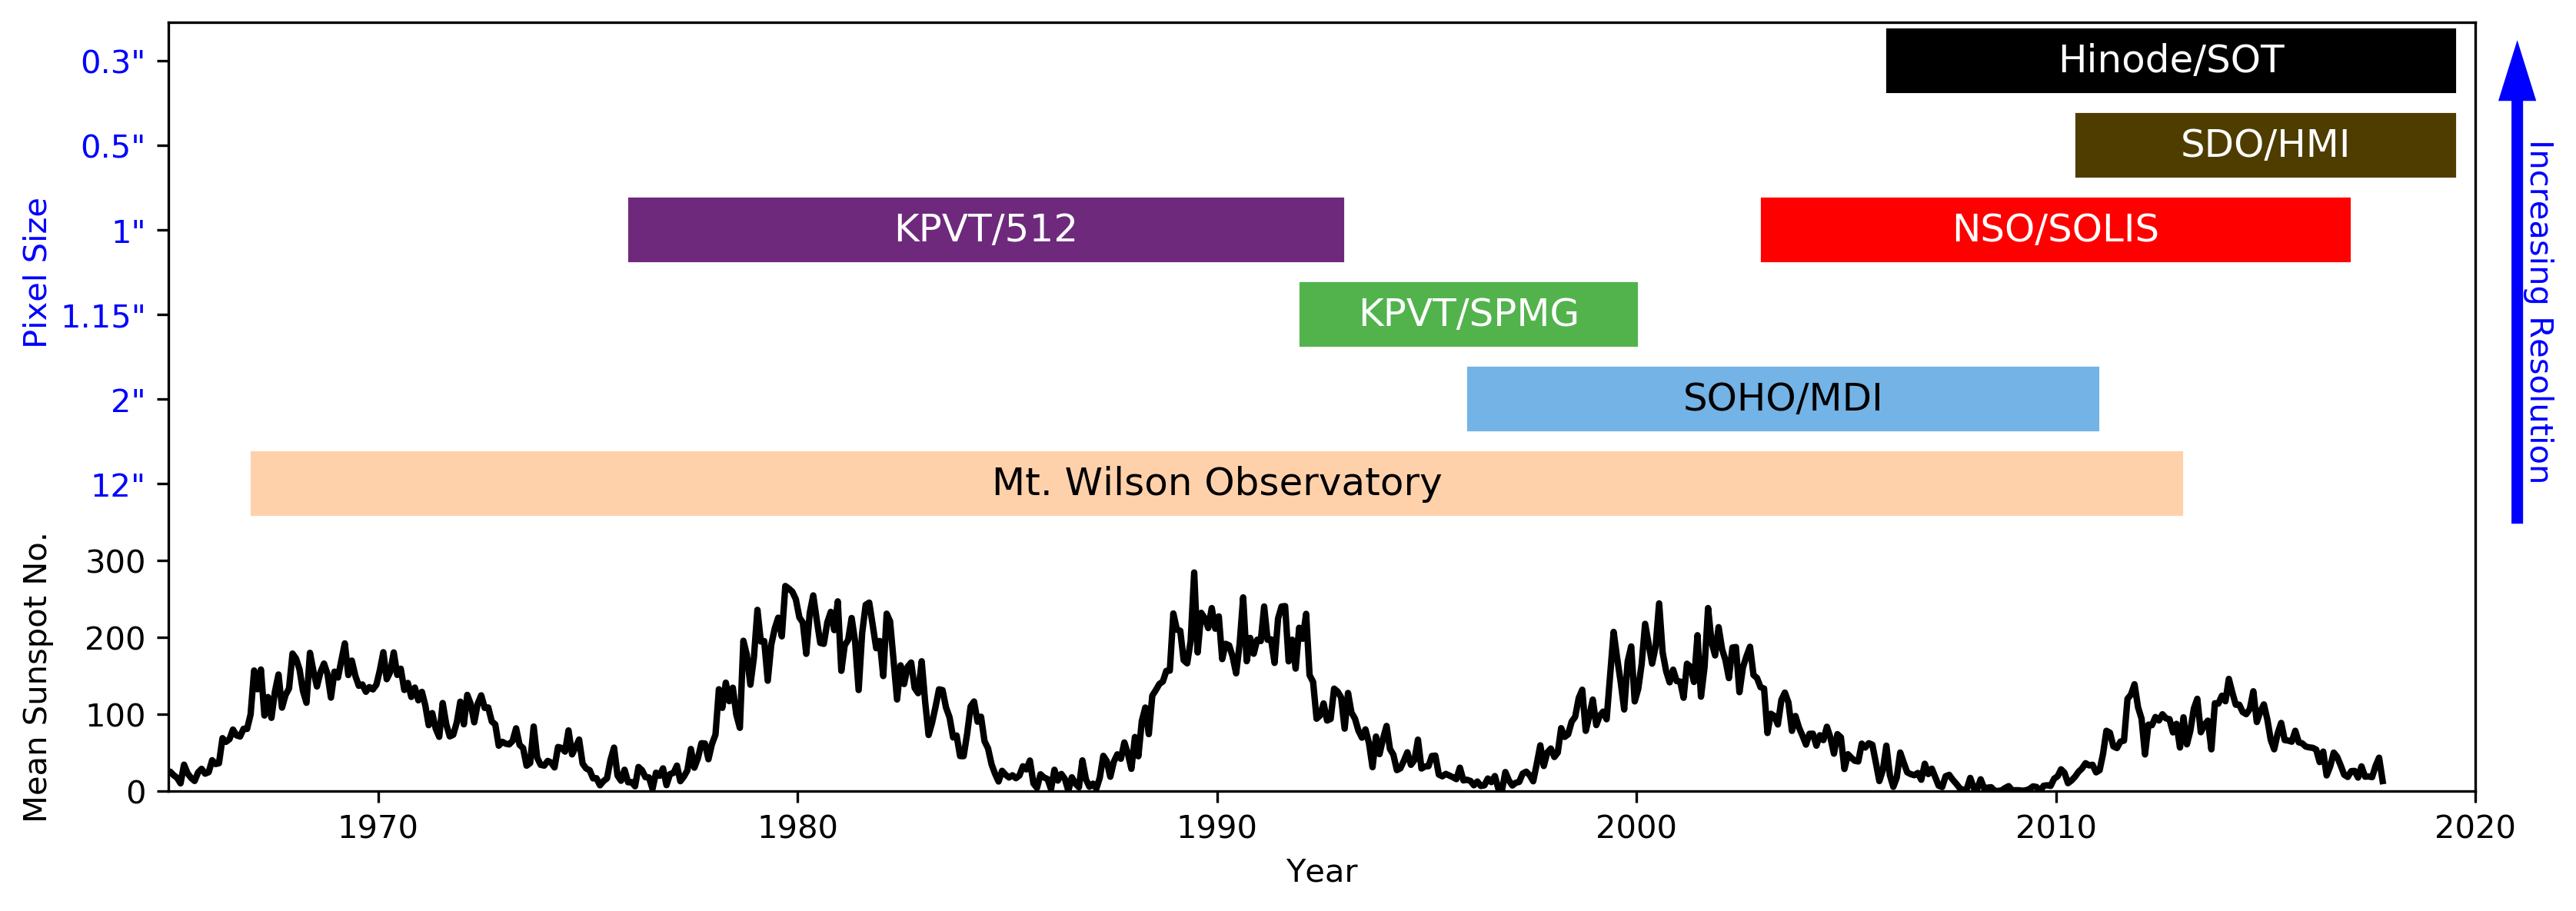

In [8]:
SILSO_Sn = pd.read_csv('Data/SSN/SN_m_tot_V2.0.csv', quotechar = '"', header = 0)

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2)

# Defining bar properties
Bw = 80  # bar width
Bg = 110 # Gap between bars
ClB = 400 # Location of center of lowest bar
ftz = 12

# Mount Wislon Observatory
x1 = 1967
x2 = 2013
y1 = ClB-Bw/2
y2 = ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = Clr[5])
ax1.text((x1+x2)/2, (y1+y2)/2, 'Mt. Wilson Observatory', color = 'k', horizontalalignment='center', verticalalignment='center', fontsize = ftz)

# SOHO/MDI
x1 = 1996
x2 = 2011
y1 = Bg+ClB-Bw/2
y2 = Bg+ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = Clr[4])
ax1.text((x1+x2)/2, (y1+y2)/2, 'SOHO/MDI', color = 'k', horizontalalignment='center', verticalalignment='center', fontsize = ftz)

# KPVT/SPMG
x1 = 1992
x2 = 2000
y1 = 2*Bg+ClB-Bw/2
y2 = 2*Bg+ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = Clr[3])
ax1.text((x1+x2)/2, (y1+y2)/2, 'KPVT/SPMG', color = 'w', horizontalalignment='center', verticalalignment='center', fontsize = ftz)

# KPVT/512
x1 = 1976
x2 = 1993
y1 = 3*Bg+ClB-Bw/2
y2 = 3*Bg+ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = Clr[2])
ax1.text((x1+x2)/2, (y1+y2)/2, 'KPVT/512', color = 'w', horizontalalignment='center', verticalalignment='center', fontsize = ftz)


# NSO/SOLIS
x1 = 2003
x2 = 2017
y1 = 3*Bg+ClB-Bw/2
y2 = 3*Bg+ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = 'r')
ax1.text((x1+x2)/2, (y1+y2)/2, 'NSO/SOLIS', color = 'w', horizontalalignment='center', verticalalignment='center', fontsize = ftz)


# SDO/HMI
x1 = 2010.5
x2 = 2019.5
y1 = 4*Bg+ClB-Bw/2
y2 = 4*Bg+ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = Clr[1])
ax1.text((x1+x2)/2, (y1+y2)/2, 'SDO/HMI', color = 'w', horizontalalignment='center', verticalalignment='center', fontsize = ftz)

# Hinode/SOT
x1 = 2006
x2 = 2019.5
y1 = 5*Bg+ClB-Bw/2
y2 = 5*Bg+ClB+Bw/2
x = np.array([x1, x1, x2, x2])
y = np.array([y1, y2, y2, y1])
ax1.fill(x,y, color = Clr[0])
ax1.text((x1+x2)/2, (y1+y2)/2, 'Hinode/SOT', color = 'w', horizontalalignment='center', verticalalignment='center', fontsize = ftz)

# Annotation
ax1.arrow(2021, 350, 0, 550, clip_on = False, head_width = 0.8, head_length = 70, width = 0.2, color = 'b')
ax1.text(2021.5, 625,'Increasing Resolution',horizontalalignment='center', verticalalignment='center', rotation = -90, color = 'b')

# Axes properties
ax1.set_xlabel('Year')
ax1.text(1961.9, 150,'Mean Sunspot No.',horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
ax1.text(1961.9, 2.5*Bg+ClB,'Pixel Size',horizontalalignment='center', verticalalignment='center', rotation = 'vertical', color = 'b')
ax1.set_yticks([0, 100, 200, 300, ClB, Bg+ClB, 2*Bg+ClB, 3*Bg+ClB, 4*Bg+ClB, 5*Bg+ClB])
ax1.set_yticklabels(['0', '100', '200', '300', '12"', '2"', '1.15"', '1"', '0.5"', '0.3"'])

# Changing tick Color
for i in range(4,10):
    ax1.get_yticklabels()[i].set_color('b')

ax1.set_xlim(left = 1965, right = 2020)
ax1.set_ylim(bottom = 0, top = 1000);

Each of the historical instruments has a different resolution, spectral response, noise level, and cadence.  **The goal of the challenge is to use deep learning to combine all these instruments into a single super-instrument with homogenous characteristics**.

This figure shows the temporal coverage of 6 historical surveys (in order of increasing resolution from top to bottom):

* **Mt. Wilson Observatory** (1967-2013): 
    * Ground-based
    * Resolution = 4" (512x512 pixels)
    * Cadence = 1 image/day
    * Full-Disk
    
    
* **SOHO/MDI** (1996-2011): 
    * Space-based
    * Resolution = 2" (1024x1024 pixels)
    * Cadence = 1 image/96 Minutes
    * Full-Disk.
    
    
* **KPVT/SPMG** (1992-2000)
    * Ground-based
    * Resolution = 1.15" (1788x1788 pixels)
    * Cadence = 1 image/day
    * Full-Disk.
    
    
* **KPVT/512** (1976-1993): 
    * Ground-based
    * Resolution = 1" (2048x2048 pixels)
    * Cadence = 1 image/day
    * Full-Disk.
    
    
* **NSO/SOLIS** (2003-2017): 
    * Ground-based - Two magnetographs using different lines
    * Resolution = 1" (2048x2048 pixels)
    * Cadence = 1 image/day
    * Full-Disk.
    

* **SDO/HMI** (2010-Present): 
    * Space-based
    * Resolution = 0.5" (4096x4096 pixels)
    * Cadence = 1 image/12 minutes
    * Full-Disk.
    

* **Hinode/SOT** (2006-Present): 
    * Space-based
    * Resolution = 0.3" (1019x512 - limited field of view)
    * Cadence = Intermitent campaigns.
    * Limited field of view
    
    
# Find Magnetograms

## Set Search Date

In [9]:
dateStr = '2011-04-01T00:00:00'
dateStr = '2010-06-03T00:00:00'
# dateStr = '1992-04-21T00:00:00'
searchDate = datetime.datetime.fromisoformat(dateStr)

## Read SDO/HMI

In [10]:
bestMatchHMI = searchMagnetograms(searchDate, instrument='HMI')
if bestMatchHMI.shape[0] > 0:
    print('Loading Fits File...', flush=True)
    bucket = client.get_bucket('fdl-mag-sdo')
    blob = storage.Blob(bestMatchHMI.loc[0,'Path'], bucket)

    blob.download_to_filename('/tmp/temp.fits')

    HMI_fits = fits.open('/tmp/temp.fits', cache=False)
    HMI_fits.verify('fix')
    dataHMI = HMI_fits[1].data

    # Assemble Sunpy map
    HMImap = sunpy.map.Map(HMI_fits[1].data, HMI_fits[1].header)

    # Fix instrument rotation
    HMImap = HMImap.rotate(rmatrix=HMImap.rotation_matrix, missing=np.nan, recenter=True)

    # Apply NaNs for Pixels outside the Sun
    x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
    hpc_coords = HMImap.pixel_to_world(x, y)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / HMImap.rsun_obs
    HMImap.data[r>1] = np.nan

Searching for closest 1 HMI results within 1 days of 2010-06-03 00:00:00 ...
done.
 
Loading Fits File...


 [astropy.io.fits.verify]


## Read SOHO/MDI

In [11]:
bestMatchMDI = searchMagnetograms(searchDate, instrument='MDI')
if bestMatchMDI.shape[0] > 0:
    print('Loading Fits File...', flush=True)
    bucket = client.get_bucket('fdl-mag-mdi')
    blob = storage.Blob(bestMatchMDI.loc[0,'Path'], bucket)

    blob.download_to_filename('/tmp/temp.fits')
    MDI_fits = fits.open('/tmp/temp.fits', cache=False)
    MDI_fits.verify('fix')
    
    # Adding missing header information
    headerMDI = MDI_fits[0].header
    headerMDI['RSUN_OBS'] = headerMDI['OBS_R0']

    # Assemble Sunpy map
    MDImap = sunpy.map.Map(MDI_fits[0].data, headerMDI)

    # Fix instrument rotation
    MDImap = MDImap.rotate(rmatrix=MDImap.rotation_matrix, missing=np.nan, recenter=True)
    print(MDImap.rotation_matrix)

    # Apply NaNs for Pixels outside the Sun
    x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
    hpc_coords = MDImap.pixel_to_world(x, y)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
    MDImap.data[r>1] = np.nan
    
    print('done.', flush=True)
    print(' ', flush=True)

Searching for closest 1 MDI results within 1 days of 2010-06-03 00:00:00 ...
done.
 
Loading Fits File...


[[1. 0.]
 [0. 1.]]
done.
 


## Read KPVT/SPMG

In [12]:
bestMatchSPMG = searchMagnetograms(searchDate, instrument='SPMG')
if bestMatchSPMG.shape[0] > 0:
    print('Loading Fits File...', flush=True)
    bucket = client.get_bucket('fdl-mag-spmg')
    blob = storage.Blob(bestMatchSPMG.loc[0,'Path'], bucket)

    blob.download_to_filename('/tmp/temp.fits')

    SPMG_fits = fits.open('/tmp/temp.fits', cache=False)
    SPMG_fits.verify('fix')
    dataSPMG = SPMG_fits[0].data[5,:,:]

    # Adding missing header information
    header = SPMG_fits[0].header
    header['cunit1'] = 'arcsec'
    header['cunit2'] = 'arcsec'
    header['CDELT1'] = header['CDELT1A']
    header['CDELT2'] = header['CDELT2A']
    header['CRVAL1'] = 0
    header['CRVAL2'] = 0
    header['RSUN_OBS'] = header['EPH_R0 ']
    header['CROTA2'] = 0
    header['CRPIX1'] = header['CRPIX1A']
    header['CRPIX2'] = header['CRPIX2A']
    header['PC2_1'] = 0
    header['PC1_2'] = 0
    header['RSUN_REF']= 696000000

    # Assemble Sunpy map
    SPMGmap = sunpy.map.Map(dataSPMG, SPMG_fits[0].header)

# # Apply NaNs for Pixels outside the Sun
# SPMGmap = SPMGmap.submap(MWFmap.bottom_left_coord,MWFmap.top_right_coord)

Searching for closest 1 SPMG results within 1 days of 2010-06-03 00:00:00 ...
done. No SPMG file found.
 


## Read NSO/SOLIS

In [13]:
bestMatchSOLIS = searchMagnetograms(searchDate, instrument='SOLIS')
if bestMatchSOLIS.shape[0] > 0:
    print('Loading Fits File...', flush=True)
    bucket = client.get_bucket('fdl-mag-solis')
    blob = storage.Blob(bestMatchSOLIS.loc[0,'Path'], bucket)

    blob.download_to_filename('/tmp/temp.fits')
    SOLIS_fits = fits.open('/tmp/temp.fits', cache=False)
    SOLIS_fits.verify('fix')

    dataSOLIS = SOLIS_fits[0].data[7,:,:]

    # Adding missing header information
    headerSOLIS = SOLIS_fits[0].header
    headerSOLIS['CUNIT1'] = 'arcsec'
    headerSOLIS['CUNIT2'] = 'arcsec'
    headerSOLIS['CDELT1'] = np.abs(headerSOLIS['CDELT1'])
    headerSOLIS['RSUN_REF']= 696000000
    headerSOLIS['RSUN_OBS'] = headerSOLIS['EPH_R0']
    headerSOLIS['CTYPE1']  = 'HPLN-TAN'                                                            
    headerSOLIS['CTYPE2']  = 'HPLT-TAN'

    # Assemble Sunpy map
    SOLISmap = sunpy.map.Map(dataSOLIS, headerSOLIS)

    # Apply NaNs for Pixels outside the Sun
    x, y = np.meshgrid(*[np.arange(v.value) for v in SOLISmap.dimensions]) * u.pixel
    hpc_coords = SOLISmap.pixel_to_world(x, y)
    r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / SOLISmap.rsun_obs
    SOLISmap.data[r>1] = np.nan
    
    print('done.', flush=True)
    print(' ', flush=True)

Searching for closest 1 SOLIS results within 1 days of 2010-06-03 00:00:00 ...
done.
 
Loading Fits File...


('hgln_obs', 'hglt_obs', 'dsun_obs')
('crln_obs', 'crlt_obs', 'dsun_obs') [sunpy.map.mapbase]


done.
 


In [14]:
SOLIS_fits[0].data[7,:,:].shape

(2048, 2048)

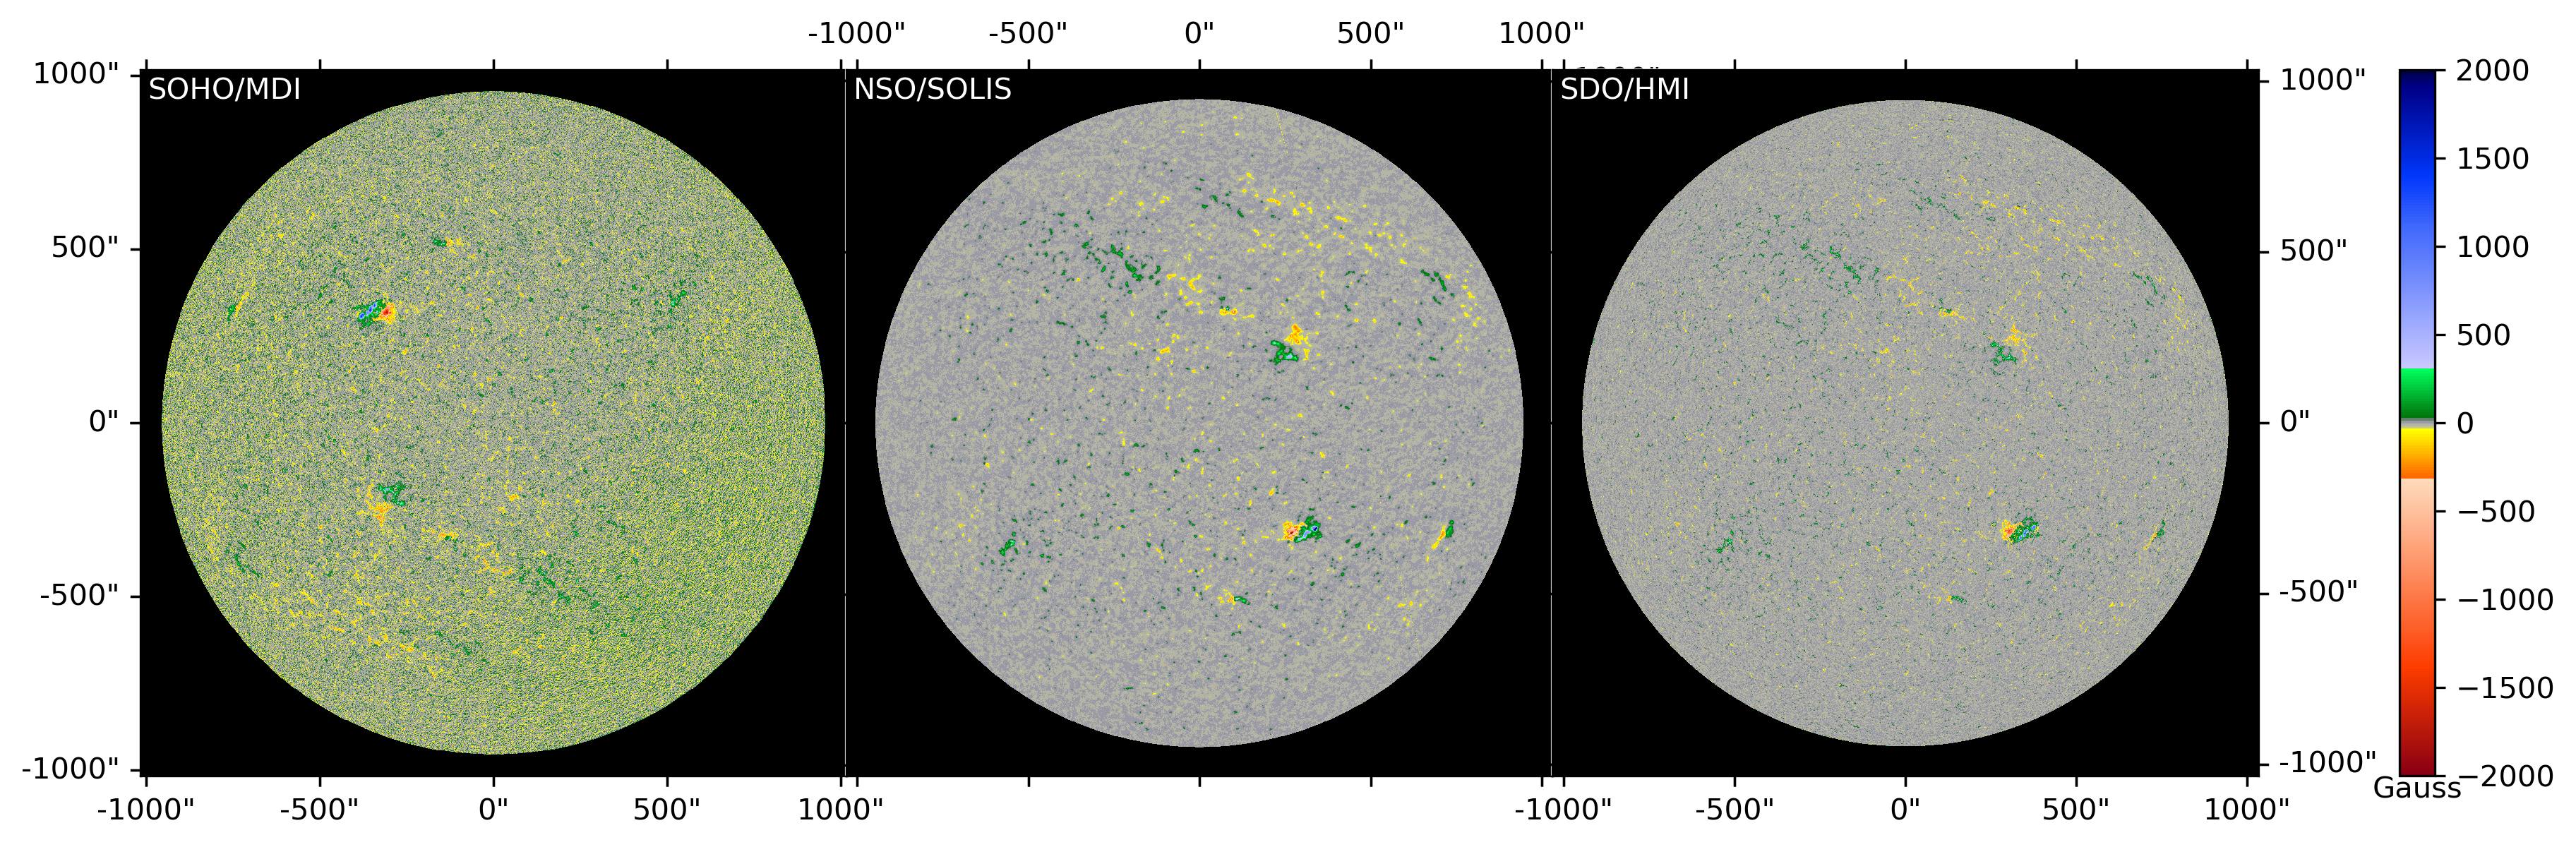

In [15]:
# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx   # Vertical size of each panel

nph = 3     # Number of horizontal panels
npv = 2     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 0 #Horizontal padding in pixels at the edge of the figure
padh2 = 50  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative units
ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
ppxy   = pxy/fszv      # Vertical size of each panel in relative units
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


## Add MDI magnetogram
if bestMatchMDI.shape[0] > 0:
    ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=MDImap)

    x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
    hpc_coords = MDImap.pixel_to_world(x, y)
    ax1.pcolormesh(x, y, MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
    ax1.grid(False)

    # # Plot SOT field of view
    # xSOT = [SOTmap.bottom_left_coord.Tx, SOTmap.bottom_left_coord.Tx, SOTmap.top_right_coord.Tx, SOTmap.top_right_coord.Tx, SOTmap.bottom_left_coord.Tx]
    # ySOT = [SOTmap.bottom_left_coord.Ty, SOTmap.top_right_coord.Ty, SOTmap.top_right_coord.Ty, SOTmap.bottom_left_coord.Ty, SOTmap.bottom_left_coord.Ty]
    # coord = SkyCoord(xSOT, ySOT, frame=MDImap.coordinate_frame)
    # ax1.plot_coord(coord,'k',linewidth = 0.5)

    ax1.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)


## Add SOLIS magnetogram
if bestMatchSOLIS.shape[0] > 0:
    ax2 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy], projection=SOLISmap)

    x, y = np.meshgrid(*[np.arange(v.value) for v in SOLISmap.dimensions]) * u.pixel
    hpc_coords = SOLISmap.pixel_to_world(x, y)
    mesh = ax2.pcolormesh(x, y, SOLISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

    # # Plot SOT field of view
    # coord = SkyCoord(xSOT, ySOT, frame=SOLISmap.coordinate_frame)
    # ax2.plot_coord(coord,'k',linewidth = 0.5)
    ax2.grid(False)

    ax2.text(0.01, 0.99, 'NSO/SOLIS', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)

    lon = ax2.coords[0]
    lon.set_ticklabel_position('t')

    lat = ax2.coords[1]
    lat.set_ticklabel_position('r')


## Add HMI magnetogram
if bestMatchHMI.shape[0] > 0:
    ax3 = fig.add_axes([ppadh+2*ppxx, ppadv, ppxx, ppxy], projection=HMImap)

    x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
    hpc_coords = HMImap.pixel_to_world(x, y)
    mesh = ax3.pcolormesh(x, y, HMImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

#     # Plot SOT field of view
#     coord = SkyCoord(xSOT, ySOT, frame=HMImap.coordinate_frame)
#     ax3.plot_coord(coord,'k',linewidth = 0.5)
    ax3.grid(False)

    ax3.text(0.01, 0.99, 'SDO/HMI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax3.transAxes)

    lat = ax3.coords[1]
    lat.set_ticklabel_position('r')


## Add colorbar
axcb = fig.add_axes([ppadh+4*ppadh2+3*ppxx, ppadv, ppadh2, ppxy])
cmap = current_cmap
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
                                norm=norm)

axcb.text(0.5, 0, 'Gauss', horizontalalignment='center', verticalalignment='top', color = 'k', transform=axcb.transAxes);


## Read Hinode/SOT

In [16]:
# # Read File
# SOTfile = 'Data/SOT/20110401_002004.fits'

# SOT_fits = fits.open(SOTfile, cache=False)
# dataSOT = SOT_fits[1].data

# # Calculate Line-of-Sight Magnetic Field
# dataSOT = np.cos(SOT_fits[2].data*np.pi/180)*SOT_fits[1].data

# # Adding missing header information
# headerH = SOT_fits[0].header
# headerH['cunit1'] = 'arcsec'
# headerH['cunit2'] = 'arcsec'
# headerH['CDELT1'] = headerH['XSCALE']
# headerH['CDELT2'] = headerH['YSCALE']
# headerH['CRVAL1'] = headerH['XCEN']
# headerH['CRVAL2'] = headerH['YCEN']
# headerH['RSUN_OBS'] = headerH['SOLAR_RA']
# headerH['CROTA2'] = headerH['B_ANGLE']
# headerH['CRPIX1'] = dataSOT.shape[1]/2
# headerH['CRPIX2'] = dataSOT.shape[0]/2
# headerH['RSUN_REF'] = 696000000
# headerH['DATE-OBS'] = headerH['TEND']

# # Assemble Sunpy map
# SOTmap = sunpy.map.Map(dataSOT, headerH)

# # Apply NaNs for Pixels outside the Sun
# x, y = np.meshgrid(*[np.arange(v.value) for v in SOTmap.dimensions]) * u.pixel
# hpc_coords = SOTmap.pixel_to_world(x, y)
# r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / SOTmap.rsun_obs
# SOTmap.data[r>1] = np.nan

## Use Differential Rotation to Equalize SOLIS' Positions to SOT

In [17]:
# ## Apply differential rotation
# newcoords = dr.solar_rotate_coordinate(hpc_coords, time = SOTmap.date)

# # Flatten
# x2 = newcoords.Tx.flatten()
# y2 = newcoords.Ty.flatten()
# x1 = hpc_coords.Tx.flatten()
# y1 = hpc_coords.Ty.flatten()
# old_mg = SOLISmap.data.flatten()
# dim1 = SOLISmap.dimensions

# # Make sure it only operates on finite pixels
# ind = (np.isfinite(x1) * np.isfinite(y1) * np.isfinite(x2) * np.isfinite(y2) * np.isfinite(old_mg))

# # Interpolate into new  position
# interp_data = griddata((x2[ind], y2[ind]), old_mg[ind], (x1[ind], y1[ind]), method='cubic')
# new_mg = np.full((int(dim1[0].value), int(dim1[1].value)), np.nan)
# new_mg.ravel()[ind] = interp_data

# # Create map
# headerS['DATE-OBS'] = headerH['TEND']
# headerS['DATE_OBS'] = headerH['TEND']

# # Assemble Sunpy map
# SOLISmap = sunpy.map.Map(new_mg, headerS)

# # Crop Field of view to match HMI
# SOLISmap = SOLISmap.submap(HMImap.bottom_left_coord,HMImap.top_right_coord)

In [18]:
# # Size definitions
# dpi = 300
# pxx = 1000   # Horizontal size of each panel
# pxy = pxx   # Vertical size of each panel

# nph = 3     # Number of horizontal panels
# npv = 1     # Number of vertical panels 

# # Padding
# padv  = 0  #Vertical padding in pixels
# padv2 = 0  #Vertical padding in pixels between panels
# padh  = 0 #Horizontal padding in pixels at the edge of the figure
# padh2 = 50  #Horizontal padding in pixels between panels

# # Figure sizes in pixels
# fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
# fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# # Conversion to relative units
# ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
# ppxy   = pxy/fszv      # Vertical size of each panel in relative units
# ppadv  = padv/fszv     #Vertical padding in relative units
# ppadv2 = padv2/fszv    #Vertical padding in relative units
# ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
# ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


# ## Start Figure
# fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# ## Add MDI magnetogram
# ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=MDImap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
# hpc_coords = MDImap.pixel_to_world(x, y)
# ax1.pcolormesh(x, y, MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax1.grid(False)

# # Plot SOT field of view
# xSOT = [SOTmap.bottom_left_coord.Tx, SOTmap.bottom_left_coord.Tx, SOTmap.top_right_coord.Tx, SOTmap.top_right_coord.Tx, SOTmap.bottom_left_coord.Tx]
# ySOT = [SOTmap.bottom_left_coord.Ty, SOTmap.top_right_coord.Ty, SOTmap.top_right_coord.Ty, SOTmap.bottom_left_coord.Ty, SOTmap.bottom_left_coord.Ty]
# coord = SkyCoord(xSOT, ySOT, frame=MDImap.coordinate_frame)
# ax1.plot_coord(coord,'k',linewidth = 0.5)

# ax1.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)


# ## Add SOLIS magnetogram
# ax2 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy], projection=SOLISmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in SOLISmap.dimensions]) * u.pixel
# hpc_coords = SOLISmap.pixel_to_world(x, y)
# mesh = ax2.pcolormesh(x, y, SOLISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

# # Plot SOT field of view
# coord = SkyCoord(xSOT, ySOT, frame=SOLISmap.coordinate_frame)
# ax2.plot_coord(coord,'k',linewidth = 0.5)
# ax2.grid(False)

# ax2.text(0.01, 0.99, 'NSO/SOLIS', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)

# lon = ax2.coords[0]
# lon.set_ticklabel_position('t')

# lat = ax2.coords[1]
# lat.set_ticklabel_position('r')


# ## Add HMI magnetogram
# ax3 = fig.add_axes([ppadh+2*ppxx, ppadv, ppxx, ppxy], projection=HMImap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in HMImap.dimensions]) * u.pixel
# hpc_coords = HMImap.pixel_to_world(x, y)
# mesh = ax3.pcolormesh(x, y, HMImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)

# # Plot SOT field of view
# coord = SkyCoord(xSOT, ySOT, frame=HMImap.coordinate_frame)
# ax3.plot_coord(coord,'k',linewidth = 0.5)
# ax3.grid(False)

# ax3.text(0.01, 0.99, 'SDO/HMI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax3.transAxes)

# lat = ax3.coords[1]
# lat.set_ticklabel_position('r')


# ## Add colorbar
# axcb = fig.add_axes([ppadh+4*ppadh2+3*ppxx, ppadv, ppadh2, ppxy])
# cmap = current_cmap
# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
#                                 norm=norm)

# axcb.text(0.5, 0, 'Gauss', horizontalalignment='center', verticalalignment='top', color = 'k', transform=axcb.transAxes);


SOHO/MDI *(left)* and SDO/HMI *(right)* magnetograms.   The field of view of Hinode/SOT is shown as a thin black box.

# Zoom into Hinode/SOT Field of View

In [19]:
# # Create maps with cropped field of view
# MDISmap = MDImap.submap(SOTmap.bottom_left_coord,SOTmap.top_right_coord)
# HMISmap = HMImap.submap(SOTmap.bottom_left_coord,SOTmap.top_right_coord)
# SOLISSmap = SOLISmap.submap(SOTmap.bottom_left_coord,SOTmap.top_right_coord)

In [20]:
# # Size definitions
# dpi = 300
# pxx = 3000   # Horizontal size of each panel
# pxy = pxx*SOTmap.data.shape[0]/SOTmap.data.shape[1]   # Vertical size of each panel

# nph = 1     # Number of horizontal panels
# npv = 3     # Number of vertical panels 

# # Padding
# padv  = 0  #Vertical padding in pixels
# padv2 = 0  #Vertical padding in pixels between panels
# padh  = 0 #Horizontal padding in pixels at the edge of the figure
# padh2 = 50  #Horizontal padding in pixels between panels

# # Figure sizes in pixels
# fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
# fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# # Conversion to relative units
# ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
# ppxy   = pxy/fszv      # Vertical size of each panel in relative units
# ppadv  = padv/fszv     #Vertical padding in relative units
# ppadv2 = padv2/fszv    #Vertical padding in relative units
# ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
# ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units

# ## Start Figure
# fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# ## Add MDI magnetogram
# ax1 = fig.add_axes([ppadh, ppadv+3*ppxy, ppxx, ppxy], projection=MDISmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MDISmap.dimensions]) * u.pixel
# hpc_coords = MDISmap.pixel_to_world(x, y)
# ax1.pcolormesh(x, y, MDISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax1.grid(False)

# ax1.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize = 20)


# ## Add SOLIS magnetogram
# ax4 = fig.add_axes([ppadh, ppadv+2*ppxy, ppxx, ppxy], projection=SOLISSmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in SOLISSmap.dimensions]) * u.pixel
# hpc_coords = SOLISSmap.pixel_to_world(x, y)
# ax4.pcolormesh(x, y, SOLISSmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax4.grid(False)

# ax4.text(0.01, 0.99, 'NSO/SOLIS', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax4.transAxes, fontsize = 20)


# ## Add HMI magnetogram
# ax2 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy], projection=HMISmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in HMISmap.dimensions]) * u.pixel
# hpc_coords = HMISmap.pixel_to_world(x, y)
# mesh = ax2.pcolormesh(x, y, HMISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax2.grid(False)

# ax2.text(0.01, 0.99, 'SDO/HMI', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax2.transAxes, fontsize = 20)


# ## Add SOT magnetogram
# ax3 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=SOTmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in SOTmap.dimensions]) * u.pixel
# hpc_coords = SOTmap.pixel_to_world(x, y)
# mesh = ax3.pcolormesh(x, y, SOTmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax3.grid(False)

# ax3.text(0.01, 0.99, 'Hinode/SOT', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax3.transAxes, fontsize = 20);

Cut out using Hinode/SOT's field of view.  This field of view is shown in the previous image as a black rectangle.



# Sample Magnetograms - Historic Era

## Read Mt. Wilson Observatory

In [21]:
# # Read File
# MWFfile = 'Data/MW/m991211_1896_0na1.fits'

# MWF_fits = fits.open(MWFfile, cache=False)
# MWF_fits.verify('fix')
# dataMWF = MWF_fits[0].data

# # Adding missing header information
# header = MWF_fits[0].header
# header['CUNIT1'] = 'arcsec'
# header['CUNIT2'] = 'arcsec'
# header['CDELT1'] = header['DXB_IMG']
# header['CDELT2'] = header['DYB_IMG']
# header['CRVAL1'] = 0.0
# header['CRVAL2'] = 0.0
# header['RSUN_OBS'] = (header['R0'])*header['DXB_IMG']
# header['CROTA2'] = 0.0
# header['CRPIX1'] = header['X0']
# header['CRPIX2'] = header['Y0']
# header['T_OBS']   = '1999.12.11_12:00:00_TAI'
# header['DATE-OBS']   = '1999.12.11_12:00:00_TAI'
# header['DATE_OBS']   = '1999.12.11_12:00:00_TAI'
# header['RSUN_REF']= 696000000
# header['CTYPE1']  = 'HPLN-TAN'                                                            
# header['CTYPE2']  = 'HPLT-TAN'

# # Assemble Sunpy map
# MWFmap = sunpy.map.Map(MWF_fits[0].data, header)

# # Apply NaNs for Pixels outside the Sun
# x, y = np.meshgrid(*[np.arange(v.value) for v in MWFmap.dimensions]) * u.pixel
# hpc_coords = MWFmap.pixel_to_world(x, y)
# r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MWFmap.rsun_obs
# MWFmap.data[r>1] = np.nan

## Read SOHO/MDI

In [22]:
# # Read File
# MDIfile = 'Data/MDI/mdi.fd_M_96m_lev182.19991211_173600_TAI.data.fits'

# MDI_fits = fits.open(MDIfile, cache=False)
# MDI_fits.verify('fix')
# dataMDI = MDI_fits[1].data

# # Assemble Sunpy map
# MDImap = sunpy.map.Map(MDI_fits[1].data, MDI_fits[1].header)

# # Fix instrument rotation
# MDImap = MDImap.rotate(rmatrix=MDImap.rotation_matrix, missing=np.nan, recenter=True)

# # Apply NaNs for Pixels outside the Sun
# x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
# hpc_coords = MDImap.pixel_to_world(x, y)
# r = np.sqrt(hpc_coords.Tx ** 2 + hpc_coords.Ty ** 2) / MDImap.rsun_obs
# MDImap.data[r>1] = np.nan

# # Crop Field of view to match MWO
# MDImap = MDImap.submap(MWFmap.bottom_left_coord,MWFmap.top_right_coord)

## Read KPVT/SPMG

In [23]:
# SPMGfile = 'Data/SPMG/spmg_eo000_C1_19991211_1740.fits'

# SPMG_fits = fits.open(SPMGfile, cache=False)
# SPMG_fits.verify('fix')
# dataSPMG = SPMG_fits[0].data[5,:,:]

# # Adding missing header information
# header = SPMG_fits[0].header
# header['cunit1'] = 'arcsec'
# header['cunit2'] = 'arcsec'
# header['CDELT1'] = header['CDELT1A']
# header['CDELT2'] = header['CDELT2A']
# header['CRVAL1'] = 0
# header['CRVAL2'] = 0
# header['RSUN_OBS'] = header['EPH_R0 ']
# header['CROTA2'] = 0
# header['CRPIX1'] = header['CRPIX1A']
# header['CRPIX2'] = header['CRPIX2A']
# header['PC2_1'] = 0
# header['PC1_2'] = 0
# header['RSUN_REF']= 696000000

# # Assemble Sunpy map
# SPMGmap = sunpy.map.Map(dataSPMG, SPMG_fits[0].header)

# # Apply NaNs for Pixels outside the Sun
# SPMGmap = SPMGmap.submap(MWFmap.bottom_left_coord,MWFmap.top_right_coord)

## Specify arbitrary region for zoom-in

In [24]:
# bottom_left_coord = SkyCoord(200*u.arcsec, 0*u.arcsec, frame=MWFmap.coordinate_frame)
# top_right_coord = SkyCoord(750*u.arcsec, 300*u.arcsec, frame=MWFmap.coordinate_frame)

In [25]:
# # Size definitions
# dpi = 300
# pxx = 1000   # Horizontal size of each panel
# pxy = pxx   # Vertical size of each panel

# nph = 2     # Number of horizontal panels
# npv = 1     # Number of vertical panels 

# # Padding
# padv  = 0  #Vertical padding in pixels
# padv2 = 0  #Vertical padding in pixels between panels
# padh  = 0 #Horizontal padding in pixels at the edge of the figure
# padh2 = 50  #Horizontal padding in pixels between panels

# # Figure sizes in pixels
# fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
# fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# # Conversion to relative units
# ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
# ppxy   = pxy/fszv      # Vertical size of each panel in relative units
# ppadv  = padv/fszv     #Vertical padding in relative units
# ppadv2 = padv2/fszv    #Vertical padding in relative units
# ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
# ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units

# ## Start Figure
# fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# ## Add Mt. Wilson magnetogram
# ax1 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=MWFmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MWFmap.dimensions]) * u.pixel
# hpc_coords = MWFmap.pixel_to_world(x, y)
# ax1.pcolormesh(x, y, MWFmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax1.grid(False)

# # Plot Zoom-in field of view
# xZOOM = [bottom_left_coord.Tx, bottom_left_coord.Tx, top_right_coord.Tx, top_right_coord.Tx, bottom_left_coord.Tx]
# yZOOM = [bottom_left_coord.Ty, top_right_coord.Ty, top_right_coord.Ty, bottom_left_coord.Ty, bottom_left_coord.Ty]
# coord = SkyCoord(xZOOM, yZOOM, frame=SPMGmap.coordinate_frame, unit = u.arcsec)

# ax1.plot_coord(coord,'k',linewidth = 0.5)

# ax1.text(0.01, 0.99, 'Mt. Wilson', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax1.transAxes)


# ## Add MDI magnetogram
# ax3 = fig.add_axes([ppadh+ppxx, ppadv, ppxx, ppxy], projection=MDImap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MDImap.dimensions]) * u.pixel
# hpc_coords = MDImap.pixel_to_world(x, y)
# ax3.pcolormesh(x, y, MDImap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax3.grid(False)

# # Plot Zoom-in field of view
# coord = SkyCoord(xZOOM, yZOOM, frame=MDImap.coordinate_frame)
# ax3.plot_coord(coord,'k',linewidth = 0.5)


# ax3.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax3.transAxes)

# lat = ax3.coords[1]
# lat.set_ticklabel_position('r')


# ## Add SPMG magnetogram
# ax2 = fig.add_axes([ppadh+2*ppxx, ppadv, ppxx, ppxy], projection=SPMGmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in SPMGmap.dimensions]) * u.pixel
# hpc_coords = SPMGmap.pixel_to_world(x, y)
# ax2.pcolormesh(x, y, SPMGmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax2.grid(False)

# # Plot Zoom-in field of view
# coord = SkyCoord(xZOOM, yZOOM, frame=SPMGmap.coordinate_frame)
# ax2.plot_coord(coord,'k',linewidth = 0.5)


# ax2.text(0.01, 0.99, 'KPVT/SPMG', horizontalalignment='left', verticalalignment='top', color = 'w', transform=ax2.transAxes)

# lat = ax2.coords[1]
# lat.set_ticklabel_position('r')


# ## Add colorbar
# axcb = fig.add_axes([ppadh+4*ppadh2+3*ppxx, ppadv, ppadh2, ppxy])
# cmap = current_cmap
# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cb1 = mpl.colorbar.ColorbarBase(axcb, cmap=cmap,
#                                 norm=norm)

# axcb.text(0.5, 0, 'Gauss', horizontalalignment='center', verticalalignment='top', color = 'k', transform=axcb.transAxes);


# Zoom Into Arbitrary Field of View

In [26]:
# # Create maps with cropped field of view
# MWFSmap = MWFmap.submap(bottom_left_coord,top_right_coord)
# MDISmap = MDImap.submap(bottom_left_coord,top_right_coord)
# SPMGSmap = SPMGmap.submap(bottom_left_coord,top_right_coord)

In [27]:
# # Size definitions
# dpi = 300
# pxx = 3000   # Horizontal size of each panel
# pxy = pxx*300/550   # Vertical size of each panel

# nph = 1     # Number of horizontal panels
# npv = 3     # Number of vertical panels 

# # Padding
# padv  = 0  #Vertical padding in pixels
# padv2 = 0  #Vertical padding in pixels between panels
# padh  = 0 #Horizontal padding in pixels at the edge of the figure
# padh2 = 50  #Horizontal padding in pixels between panels

# # Figure sizes in pixels
# fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
# fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# # Conversion to relative units
# ppxx   = pxx/fszh      # Horizontal size of each panel in relative units
# ppxy   = pxy/fszv      # Vertical size of each panel in relative units
# ppadv  = padv/fszv     #Vertical padding in relative units
# ppadv2 = padv2/fszv    #Vertical padding in relative units
# ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
# ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units

# ## Start Figure
# fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)


# ## Add Mt. Wilson magnetogram
# ax1 = fig.add_axes([ppadh, ppadv+2*ppxy, ppxx, ppxy], projection=MWFSmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MWFSmap.dimensions]) * u.pixel
# hpc_coords = MWFSmap.pixel_to_world(x, y)
# ax1.pcolormesh(x, y, MWFSmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax1.grid(False)

# ax1.text(0.01, 0.99, 'Mt. Wilson Observatory', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax1.transAxes, fontsize = 20)


# ## Add SPMG magnetogram
# ax2 = fig.add_axes([ppadh, ppadv+ppxy, ppxx, ppxy], projection=MDISmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in MDISmap.dimensions]) * u.pixel
# hpc_coords = MDISmap.pixel_to_world(x, y)
# mesh = ax2.pcolormesh(x, y, MDISmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax2.grid(False)

# ax2.text(0.01, 0.99, 'SOHO/MDI', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax2.transAxes, fontsize = 20)


# ## Add SOT magnetogram
# ax3 = fig.add_axes([ppadh, ppadv, ppxx, ppxy], projection=SPMGSmap)

# x, y = np.meshgrid(*[np.arange(v.value) for v in SPMGSmap.dimensions]) * u.pixel
# hpc_coords = SPMGSmap.pixel_to_world(x, y)
# mesh = ax3.pcolormesh(x, y, SPMGSmap.data, vmin=vmin, vmax=vmax, cmap = current_cmap)
# ax3.grid(False)

# ax3.text(0.01, 0.99, 'KPVT/SPMG', horizontalalignment='left', verticalalignment='top', color = 'k', transform=ax3.transAxes, fontsize = 20);

Cut out using an arbitrary field of view.  This field of view is shown in the previous image as a black rectangle.